# Implement simple NN model for classification

For this notebook, we will just use MNIST for basic analysis. The purpose is to play with a simple network in pytorch for image classification and tinker with batch norm.  

In [5]:
# imports
import os
import csv
import json
import random
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import HTML, display

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev, torch.get_num_threads()

(device(type='cpu'), 4)

# Get MNIST data
Load directly from torchvision

In [7]:
# Define transorms to apply to data
transform = [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]
batch_size_train, batch_size_test = 64, 1000

# Get training data
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data/', train=True, download=True,
                transform=transforms.Compose(transform)),batch_size=batch_size_train, shuffle=True)

# Get test data
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data/', train=False, download=True,
                             transform=transforms.Compose(transform)),batch_size=batch_size_test, shuffle=True)

9913344it [00:01, 6619801.94it/s]                             


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



29696it [00:00, 12877796.90it/s]         

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




1649664it [00:00, 8488192.20it/s]                            


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



5120it [00:00, 10802231.63it/s]         


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Let's define a simple network with just a activation(layer) for layer

In [3]:
# Set up simple network with user defined activation function and numbber of layer units
class Net(nn.Module):
    def __init__(self, actv, num_inputs, hidden_units, num_outputs):
        super(Net, self).__init__()
        # Get activation function
        exec('self.actv = nn.%s'%actv)   
        # Define layers
        self.layers = nn.ModuleList()
        for i in range(len(hidden_units)):
          next_num_inputs = hidden_units[i] 
          self.layers += [nn.Linear(num_inputs, next_num_inputs)]
          num_inputs = next_num_inputs

        self.out = nn.Linear(num_inputs, num_outputs)
        
    # Make the forward pass
    def forward(self, x):
        # Flattening
        x = x.view(x.shape[0], -1)  
        
        # Apply activation function to each layer on the input 
        for layer in self.layers:
          x = self.actv(layer(x))
        x = self.out(x)
        return x

Now let's define a main() function for doing the train/test

In [12]:
def progress(epoch, loss, epochs=100):
    return HTML("""
        <label for="file">Training loss: {loss}</label>
        <progress
            value='{epoch}'
            max='{epochs}',
            style='width: 100%'
        >
            {epoch}
        </progress>
    """.format(loss=loss, epoch=epoch, epochs=epochs))


# Define training function
def test(data_loader):
  correct = 0
  total = 0
  for (inputs, labels) in data_loader:
      # inputs = inputs.to(dev).float()
      # labels = labels.to(dev).long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return total, acc


def main(net, criterion, optimizer,train_loader,num_epochs=1, verbose=True, training_plot=True):
  if verbose:
    progress_bar = display(progress(0, 0, num_epochs), display_id=True)

  # Set to train = true
  net.train()
  training_losses = []

  for epoch in range(num_epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, (inputs,labels) in enumerate(train_loader, 0):
          # # get the inputs; data is a list of [inputs, labels]
          # inputs, labels = data
          # inputs = inputs.to(dev).float()
          # labels = labels.to(dev).long()

          # zero the parameter gradients
          optimizer.zero_grad()

          # Make forward pass
          outputs = net(inputs)

          # Compute Loss
          loss = criterion(outputs, labels)

          # Make backward pass and step optimizer
          loss.backward()
          optimizer.step()

          # Print statistics
          if verbose:
            training_losses += [loss.item()]
            running_loss += loss.item()
            if i % 10 == 9:    # update every 10 mini-batches
                progress_bar.update(progress(epoch+1, running_loss / 10, num_epochs))
                running_loss = 0.0
  
  # Evaluate net
  net.eval()

  train_total, train_acc = test(train_loader)

  if verbose:
    print('Accuracy on the %d training samples: %0.2f %%' % (train_total, train_acc))

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()
  
  return train_acc


In [10]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 28, 28])

In [17]:
hidden_layers = [32]
# net = BNDeepNet().to(dev) 
net = Net('ReLU()', 1*28*28, hidden_layers, 10).to(dev) 
criterion = nn.CrossEntropyLoss()  #nn.MultiMarginLoss(margin=1.0) 
optimizer = optim.SGD(net.parameters(),lr=1e-2)#,momentum=0.5)# optim.Adam(net.parameters(), lr=1e-4)
train_acc = main(net, criterion, optimizer,train_loader,num_epochs=500)

KeyboardInterrupt: 

In [ ]:
# # @title Helper functions
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.axis(False)
#     plt.show()

# def progress(epoch, loss, epochs=100):
#     return HTML("""
#         <label for="file">Training loss: {loss}</label>
#         <progress
#             value='{epoch}'
#             max='{epochs}',
#             style='width: 100%'
#         >
#             {epoch}
#         </progress>
#     """.format(loss=loss, epoch=epoch, epochs=epochs))

In [ ]:
class BNDeepNet(nn.Module):
    def __init__(self):
        super(BNDeepNet, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 3)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        return x

In [ ]:
data = np.array(df)

X_train = torch.tensor(data[:, 1:]).float()/255
y_train = torch.tensor(data[:, 0]).long()

In [ ]:
batch_size = 128
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                        shuffle=True, num_workers=10)

In [ ]:
def train_test_classification(net, criterion, optimizer,
                              train_loader,
                              num_epochs=1, verbose=True,
                              training_plot=True):
  if verbose:
    progress_bar = display(progress(0, 0, num_epochs), display_id=True)

  net.train()
  training_losses = []
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, (inputs,labels) in enumerate(train_loader, 0):
          # # get the inputs; data is a list of [inputs, labels]
          # inputs, labels = data
          # inputs = inputs.to(dev).float()
          # labels = labels.to(dev).long()

          # zero the parameter gradients
          optimizer.zero_grad()

          # Make forward pass
          outputs = net(inputs)

          # Compute Loss
          loss = criterion(outputs, labels)

          # Make backward pass and step optimizer
          loss.backward()
          optimizer.step()

          # Print statistics
          if verbose:
            training_losses += [loss.item()]
            running_loss += loss.item()
            if i % 10 == 9:    # update every 10 mini-batches
                progress_bar.update(progress(epoch+1, running_loss / 10, num_epochs))
                running_loss = 0.0
  
  # Evaluate net
  net.eval()

  # Define training function
  def test(data_loader):
    correct = 0
    total = 0
    for (inputs, labels) in data_loader:
        # inputs = inputs.to(dev).float()
        # labels = labels.to(dev).long()

        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc


  train_total, train_acc = test(train_loader)

  if verbose:
    print('Accuracy on the %d training samples: %0.2f %%' % (train_total, train_acc))

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()
  
  return train_acc

Accuracy on the 14592 training samples: 99.93 %


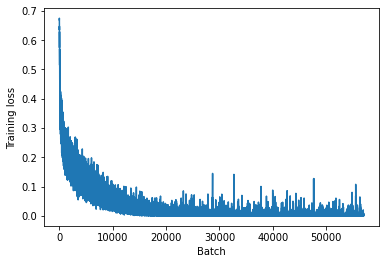

In [ ]:
hidden_layers = [128, 64, 32]
batch_size = 128
# net = BNDeepNet().to(dev) 
net = Net('ReLU()', 3*32*32, hidden_layers, 3).to(dev) 
criterion = nn.MultiMarginLoss(margin=1.0) #nn.CrossEntropyLoss()  
optimizer = optim.Adam(net.parameters(), lr=1e-4)
train_acc = train_test_classification(net, criterion, optimizer,
                                      train_loader,
                                      num_epochs=500)

In [ ]:
# Predict test set
df = pd.read_csv('test.csv')
print(df.head())
data = np.array(df)
X_test = torch.tensor(data).float()/255



net.eval()
y_pred = net(X_test.to(dev))
labels_pred = torch.argmax(y_pred, dim=1)


   pixel1  pixel2  pixel3  pixel4  ...  pixel3069  pixel3070  pixel3071  pixel3072
0     222     191     140     216  ...        181        161        139         96
1     119      76      65      32  ...        115         33         51        167
2     157      92     110     181  ...        171        141        128         86
3      93     173      78      68  ...        165         71        190        102
4     161     213      44     172  ...        207        225        189         70

[5 rows x 3072 columns]


In [ ]:
# create the submission file
header = ['ImageId', 'Label']
with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    
    for i in range(len(labels_pred)):
      writer.writerow([i+1] + [labels_pred[i].item()])

In [ ]:
# submit
!kaggle competitions submit permuted-animal-faces -f submission.csv -m " increase batch to 500 and use Net with hiddne layers  128, 64, 32] and w/multi-margin loss and lr=1e-4" #"Result with same model as in the tutorial"

100% 10.7k/10.7k [00:00<00:00, 61.1kB/s]
Successfully submitted to Permuted Animal Faces

Note that you can submit maximum 20 times a day. Participants will need to wait until the next UTC day after submitting the maximum number of daily submissions.

And finally you can hand select 2 submissions among your previous ones to be used for the final ranking.

# Part 2. Deep Learning, Deeper Thinking



## 2.1 Our Data-Processing Wish List

By now you should be pretty familiar with classifying animal faces using multi-layer perceptrons. MLPs make very few assumptions about the underlying structure of the data, which make them very flexible in approximating a wide variety of functions. However, sometimes it can be helpful to constrain the set of possible functions we want to approximate by introducing some "rules" that these functions need to follow. We call these rules **inductive biases**. 

For example, one inductive bias might be the rule that "A cat is a cat, no matter where it is placed in the image. An upper-left-corner cat is just as much of a cat as a lower-right-corner cat." That describes an inductive bias called **translational invariance**, which basically says that the class of an object is invariant to translation (it doesn't matter where it is, as long as it's there). If we could have a model that preserves translational invariance, chances are it would be helpful in finding us good models for image processing (more on this later). 

**Now that you're familiar with the concept of inductive biases, please do the following:**
* List one inductive bias other than translational invariance that would be good to have for image processing
* Suppose you're trying to develop a model to assign credit scores to people based on their personal data. What kind of inductive biases or data guarantees would you want to impose on this system?

In [ ]:
#Delete the starter text, enter your response, and run the cell.
q_2_1 = ''' Rotational invariance would also be a desireable trait of a network.
Like the example, a cat is a cat whether no matter if its rotated within the image. 

First, we might assume that all credit scores belong to some specific distribution. Second,
we an introducing bias when we hand select features (personal data in this case) to be used in the model. 
A good model of credit score should account for all aspects of fiscal behavior, but limit the use
of non-financial information. This is potentially problematic if predictors, such as race, gender, religious identity, etc. are applied. 
For example, race may end up being a strong predictor of credit score. However, this is completely
tied to social and economic inequality between racial groups. Thus, while there may be a correlation 
between this feature and race, the model would likely apply a lower credit score to individual w/o 
even considering their finances. The model is not a predictor of credit based on fiscal responsibility, but 
instead on race, gender, or other personal characteristics. 

On the other hand, if we wanted to equity into the network, we might bias our priors or introduce strong likelihoods
that produce a more favorable posterior for disenfranchised groups. While this does not treat everyone equal, we might
give certain groups a more positive bias to account for negative credit score impact from racist or sexist features. 
this type of approach may drive credit scores to be more equal in outcome, and thus, over a long time scale, might 
result in more loans and greater financial trust of underrepresented groups. 

'''

## 2.2 The Ethics of Facial Recognition
In part 1, we just had you create a network that was good at classifying faces of animals. What happens when this technologies are used on humans? What happens when these technologies are used by law enforcement? In this section, we'll explore these implications. So play your favorite Lo-Fi Beats to Study/Relax To and let's get started!


### 2.2.1 **America Under Watch**
As data scientists, we often complain that we don't have enough data. Sometimes lack of good data isn't the problem. What happens if we collect data *everywhere*? In many countries around the world, facial recognition is used by law enforcement to conduct wide-scale law enforcement. Thankfully that's not the case in the United States. Right? 

*... Right?* 

Read the following:

* https://www.americaunderwatch.com/

**In 200-300 words, please answer the following questions.** 
* In America Under Watch, the Georgetown Law Center proposes a moratorium (temporary freeze) on the police use of facial recognition. Do you agree or disagree with this choice, and why? 
* The article mentions the fact that *facial surveillance is disproportionately likely to impact communities of color and communities with lower socio-economic status (SES)*. Think about what this means about what amount + what kinds of data law enforcement collect on people of color. How might this perpetuate cycles of incarceration for people of color in the U.S.?
* If facial recognition were to be put in place in a highly secure location, like the White House, what kind of inductive biases would you want to ensure that such a system would have? What guarantees might you want to have about the data that is used to train the network, the data that is collected, and what is done with the data afterward? 



In [ ]:
#Delete the starter text, enter your response, and run the cell.
q_2_2_1 = '''
Your Response to Q 2.2.1 Here (200 - 300 words)

- A moratoriam is simply saying that we should not do it right now, but maybe later. The question is if this technology belongs in
our society at all or if we are willing to accept it as part of our security measures. While I do not support the use of widespread
facial recognition by police in public spaces, I think it is simply inevitable. We should impose a moritorium and then our focus
should be on legislation and regulation to ensure that any use of this technology is constitutional and fair. 

- The prison system is flawed in so many ways, but one of the worst issues is how we reintroduce people into society. We remove 
people from society and place them in a lonely, isolated, and violent environment for long sentences and then release them and expect
them to seamlessly rejoin society. We offer poor or no resources and impose strict probation/parole rules. Even the most minor violations,
like being 5 min late to a meeting due to delayed public transportation, can result in one being thrown back in prison. 
In my opinion, facial recognition and monitoring of those on court supervision would be akin to entrapment. No one member of society commits
zero violations of the law. We just are not held accountable for every time we exceed the speed limit, jaywalk, etc. This type of 
constant monitoring would surely result in a constant cycle of prison-release-prison, especially for individuals already targeted by police, like 
communities of color. 

- First off, we would want to ensure that the data are trained on an appropriately diverse data and then no labels are assigned to these individuals
that would allow for targeting based on class, religion, etc. A bias we would desire is signficant performance with minimal error. If a level of confidence
cannot be achieved, the image should be labeled as unrecognized, not the closest guess. In Jan 2020, a black man was arrested in Detroit based on facial
recognition in footage obtained by police. The only resemblance was the fact that both were black. While we do not know the inner workings of the network, 
many networks have a discrete set of choices and will result in some kind of output. That means that a bias in the system would impose classification scheme 
in which matches are provided based on probability. This means that the highest probability would be assigned as the match, when this may not be a close match at all,
but simply a high enough probability. 


'''

### 2.2.2 **Grab Some Popcorn**


Video available at https://youtube.com/watch?v=jZjmlJPJgug


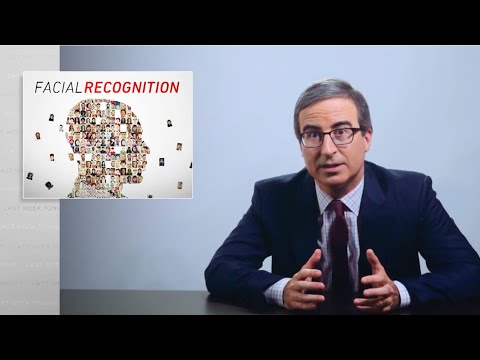

In [ ]:
#@markdown That's enough reading for today, don't you think? Grab some popcorn, run this cell, and watch this video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="jZjmlJPJgug", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

**In 200-300 words, please answer the following questions**
* In the segment, John Oliver mentions that Clearview AI uses "publicly available data", which includes public profile information on Facebook, LinkedIn, Twitter, and Instagram. Clearview argues that this information has all been willingly made public. Do you agree? Why or why not?
* Some prominent data scientists claim that "data/algorithms don't have bias, people have bias". Do you agree with this sentiment? Why or why not?


In [ ]:
#Delete the starter text, enter your response, and run the cell.
q_2_2_2 = '''
- Clearview is clearly acting outside of the law by violating social media terms of service. Just because a car is parked on the street does not mean I can own it if I get in it and start it. Publically accessible does not equal public availabitliy here. Sure, it is 
almost impossible to stop people from finding our picture on the internet, but using it as data is a violation.

- Models are trained to learn based on their structure and the data they are given. Humans choose the model structure, the loss, and then data. I think models become bias because we
push them to learn that way. I do not know if I think models are inherently bias w/o human influence. 

'''

# Submit to Airtable
**Don't forget to contribute to the conversation in your pod slack channel.** You can do so by copying and pasting some or all of the answers to the above questions, or by commenting and responding to other people's posts.


In [ ]:
import time
import numpy as np
from IPython.display import IFrame
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: q_2_1;
except NameError: q_2_1 = ""
try: q_2_2_1;
except NameError: q_2_2_1 = ""
try: q_2_2_2;
except NameError: q_2_2_2 = ""


times = np.array([t1])-t0

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "q_2_1": q_2_1,
          "q_2_2_1": q_2_2_1,
          "q_2_2_2": q_2_2_2,
          "cumulative_times": times}

src = "https://airtable.com/embed/shrzuKoahe4ZQKvND?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))